# 1. Imports & define constants

In [9]:
# !pip install adversarial-robustness-toolbox # if you need to install the adversarial-robustness-toolbox (art)

In [1]:
from art.attacks.evasion import *
from art.estimators.classification import TensorFlowV2Classifier

import numpy as np
from math import pi
from random import random, randint

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from tensorflow.keras.losses import MSE
from tensorflow.keras.losses import categorical_crossentropy as CCE
from tensorflow.keras.models import load_model

from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [16]:
# If you want to check that your modules match the specifications listed in the README

# print("pandas :", pd.__version__)
# print("sns :", sns.__version__)
# print("np :", np.__version__)

# import matplotlib ; print("matplotlib :", matplotlib.__version__)
# import tensorflow ; print("tensorflow :", tensorflow.__version__)
# import art ; print("art", art.__version__)

Initialization of specific values for the problem :

In [44]:
input_names = ['rho','theta','psi','v_own','v_int']
input_latex_names = [r'$\rho$', "$\Theta$", r'$\varphi$', "$v_{own}$", "$v_{int}$"]
ACAS_labels = ["COC","WR","WL","SR","SL"]

X_mean = np.array( [1.9791091*1e4, 0.0, 0.0, 650.0, 600.0] )
X_range = np.array( [60261.0, 6.28318530718, 6.28318530718, 1100.0, 1200.0] )
X_dom = np.array([ [0.0,    -pi, -pi, 100.0,     0.0],
                   [60760.0, pi,  pi, 1200.0, 1200.0] ])

print("> Domaine des inputs :")
inputs_domain = np.zeros((2,5))
inputs_domain[0,0] = (X_dom[0,0]-X_mean[0])/X_range[0]
inputs_domain[1,0] = (X_dom[1,0]-X_mean[0])/X_range[0]
print("- {0} : [{1},{2}]".format(input_names[0],inputs_domain[0,0],inputs_domain[1,0]))
for k in range(1,5):
    inputs_domain[0,k] = -0.5 ; inputs_domain[1,k] = 0.5
    print("- {0} : [{1},{2}]".format(input_names[k],inputs_domain[0,k],inputs_domain[1,k]))

> Domaine des inputs :
- rho : [-0.32842287715105956,0.6798577687061284]
- theta : [-0.5,0.5]
- psi : [-0.5,0.5]
- v_own : [-0.5,0.5]
- v_int : [-0.5,0.5]


Recover the clusters identified in **network_analysis.ipynb** :

In [3]:
def full_nets_id():
    """ Get the id of the 45 neural networks as pairs of two integers as string. """
    nets_id = []
    for k in range(11,60):
        if k%10 != 0:
            nets_id.append( (k//10,k%10) )
    return(nets_id)

ID2num = full_nets_id()

NETS_ID = [23,41,14,31,9,18,6,0,8] # one network in each of the 9 identified classes

NETS_NUM = [ID2num[u] for u in NETS_ID]
print("Selected networks (one in each class) : ", NETS_NUM)

Selected networks (one in each class) :  [(3, 6), (5, 6), (2, 6), (4, 5), (2, 1), (3, 1), (1, 7), (1, 1), (1, 9)]


**OPTIONAL** : Load base points that have been previously defined and save in a numpy file :

In [71]:
BASE_PTS = np.load("data_TOM/" + "FGSM_#1000_0.01_20-05/" + "base_pts.npy")
print("> Number of points : {0}".format(BASE_PTS.shape[0]))

> Number of points : 1000


# 2. Attack random points and build a confusion matrix

In [4]:
def create_random_pts(npts, boundaries=inputs_domain):
    """ Generate 'npts' random points in the domain defined by the 'boundaries'. """
    pts = np.random.rand(npts, 5)
    for f in range(0,5):
        pts[:,f] *= (boundaries[1][f] - boundaries[0][f])
        pts[:,f] += boundaries[0][f]
    return(pts)

In [5]:
def conf_matrix(pred0, pred1, n_classes=5):
    """ Creates the n_classes*n_classes confusion matrix of pred1 compared to the original pred0. 
        - cmat[i,j] = nb of pts classified as i at the origin and as j after the attack """
    cmat = np.zeros((n_classes,n_classes)).astype(int)
    n_sample = pred0.shape[0]
    for k in range(n_sample):
        cmat[pred0[k],pred1[k]] += 1
    return(cmat)

In [6]:
def norm_rows(cmat):
    """ Normalizes the lines of the confusion matrix cmat. """
    n = cmat.shape[0]
    ncmat = np.zeros((n,n))
    sum_rows = np.sum(cmat, axis=1)
    for k in range(n):
        s = sum_rows[k]
        if s != 0:
            ncmat[k,:] = cmat[k,:]/sum_rows[k]
    return(ncmat)

In [7]:
def load_attack(method, acas_model, iter=20, epsilon=0.8, etap=0.95):
    """ Choose your attack with 'method'. """
    
    if method == "nf":
        return(NewtonFool(classifier = acas_model, 
                          eta = etap, 
                          max_iter = iter,
                          verbose = True))
    
    elif method == "fgsm":
        return(FastGradientMethod(estimator = acas_model,
                                  eps = epsilon))
    
    elif method == "cw":
        return(CarliniLInfMethod(classifier = acas_model,
                                 initial_const = 1.0, 
                                 max_iter = iter, 
                                 verbose = True))
    elif method == "Deepfool":
        return DeepFool(classifier=acas_model, max_iter=iter)
    
    else:
        raise Exception("'{0}' is not a valid attack.".format(method))

In [98]:
def build_confusion_matrix(npts, method, num_net, base_pts=None, folder="/content/", show=True, savefile=None, iter=20,
                                                                                                            epsilon=0.001,
                                                                                                            etap=0.95):
    """ Do not forget to set folder and, if you use Colab, to import your neural networks ! """
    
    # 1 - Load the model ACAS
    
    if (num_net[0] in range(1,6)) and (num_net[1] in range(1,10)):
        path_model = folder + "ACASXU_{}_{}.h5".format(num_net[0], num_net[1])
        model = load_model(path_model)
        model.compile()
    else:
        raise Exception("ACAS neural network {0}-{1} doesn't exist.".format(num_net[0],num_net[1]))

    # 2 - Transform into art form
    
    ACAS_classifier = TensorFlowV2Classifier(model = model,
                                             loss_object = MSE,
                                             train_step = None,
                                             nb_classes = 5,
                                             input_shape = (1, 5),
                                             clip_values = (inputs_domain[0,:],inputs_domain[1,:]))

    attack = load_attack(method, ACAS_classifier, iter = iter,
                                                  epsilon = epsilon,
                                                  etap = etap)

    # 3 - Apply the attack on N random points
    
    if npts != 0:
        base_pts = create_random_pts(npts, boundaries=inputs_domain)
    else:
        npts = base_pts.shape[0]
    adv_pts = attack.generate(base_pts)
    
    base_pred = model.predict(base_pts)
    base_advice = np.argmin(base_pred, axis=1)
    
    adv_pred = model.predict(adv_pts)
    adv_advice = np.argmin(adv_pred, axis=1)

    # 4 - Confusion matrix
    
    cmat = conf_matrix(base_advice, adv_advice)
    base_count = (np.bincount(np.concatenate((base_advice,np.arange(0,5)))) - np.ones(5)).astype(int)
    adv_count = (np.bincount(np.concatenate((adv_advice,np.arange(0,5)))) - np.ones(5)).astype(int)
    
    # 5 - Show confusion matrix with normalized rows
    
    ncmat = norm_rows(cmat)    
    if show or (savefile!=None):
        index0 = [ACAS_labels[i] + " ({0})".format(base_count[i]) for i in range(5)]
        index1 = ["adv-" + ACAS_labels[i] + " ({0})".format(adv_count[i]) for i in range(5)]
        df_cmat = pd.DataFrame(ncmat, index = index0, columns = index1)

        plt.figure(figsize = (10,7))
        sns.heatmap(df_cmat, annot=True)
        plt.title("Confusion matrix - " + method.upper() + " - #{0}".format(N) + " - network {0}-{1}".format(num_net[0], num_net[1]))
        if show:
            plt.show()
        if savefile:
            plt.savefig(savefile)
    
    return(cmat, ncmat)

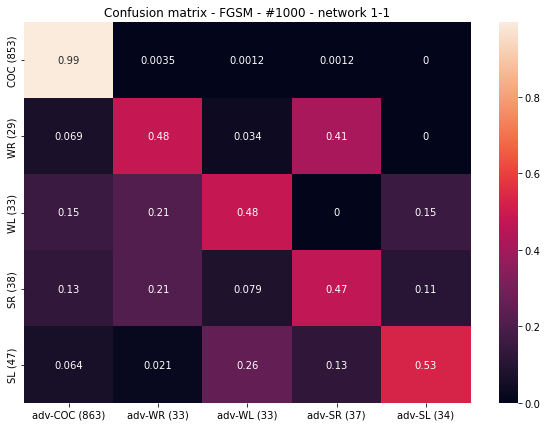

In [27]:
cmat, ncmat = build_confusion_matrix(1000, "fgsm", (1, 1), epsilon=0.001, folder="ACAS_XU_tf_keras/", show=True)

In [ ]:
# Example where we generate several cmat which are automatically saved
for eps in [0.001,0.005,0.01,0.05,0.1,0.5,1.0]:
    filename = "fgsm_cmat/cmat_eps_" + str(eps) + ".png"
    _,_ = build_confusion_matrix(10000, "fgsm", (1, 1), epsilon=eps, folder="ACAS_XU_tf_keras/", savefile=filename, show=False)
    print(eps)

# 3. Plot the evolution of the matrix coefficients when a parameter changes

Generate pts in the input domains, apply an attack on them, vary the intensity and compute the different confusion matrixes with the function ***cmat_tracking*** :

In [99]:
def cmat_tracking(npts, method, nets, base_pts=[], folder="/content/", param_range=[0], store_adv=False):
    """ Compute the evolution of the coefficients of the cmat when we explore 'param_range' with 'method'
        for each network in 'net'.
        Set npts = 0 if you want to load pre-generated points in 'base_pts'. """
    
    ## Adapt the code for the single network case
    
    if (type(nets) == tuple) and (len(nets) == 2): # a single network
        nets = [nets] ; nnet = 1
    else:
        nnet = len(nets)
        
    ## Generate N random points and create the 4D table to store the cmat
    
    if npts != 0:
        base_pts = create_random_pts(npts, boundaries=inputs_domain)
    else:
        npts = base_pts.shape[0]
    ncmat = len(param_range)
    bloc = np.zeros((nnet,ncmat+1,5,5)) # 4D table
    if store_adv:
        all_adv_pts = np.zeros((nnet,ncmat,npts,5)) # store all adversarial pts
    else:
        all_adv_pts = None
    
    ## Iter over each network
    
    print("### ========== Apply {0} on {1} nnets and {2} points and each of the {3} configurations of the parameters ========== ###\n"
              .format(method.upper(), nnet, npts, len(param_range)))
    
    for inet in range(nnet):
        num_net = nets[inet]
        
        # 1 - Load the network and compute the base pred
        
        if (num_net[0] in range(1,6)) and (num_net[1] in range(1,10)):
            path_model = folder + "ACASXU_{}_{}.h5".format(num_net[0], num_net[1])
            model = load_model(path_model)
            model.compile()
        else:
            raise Exception("ACAS neural network {0}-{1} doesn't exist.".format(num_net[0],num_net[1]))
        
        base_pred = model.predict(base_pts)
        base_advice = np.argmin(base_pred, axis=1)
        base_count = (np.bincount(np.concatenate((base_advice,np.arange(0,5)))) - np.ones(5)).astype(int)
        bloc[inet,0] = np.eye(5)*base_count # base points without any attack for each network

        # 2 - Transform into art form

        ACAS_classifier = TensorFlowV2Classifier(model = model,
                                                 loss_object = MSE,
                                                 train_step = None,
                                                 nb_classes = 5,
                                                 input_shape = (1, 5),
                                                 clip_values = (inputs_domain[0,:],inputs_domain[1,:]))

        # 4 - Iter over the param_range and attack the base_pts

        print("\n# [{5}/{6}] > Apply {0} on nnet {1}-{2} for {3} points and each of the {4} configurations of the parameters :"
              .format(method.upper(), num_net[0], num_net[1], npts, len(param_range), inet+1, nnet))

        for k in tqdm(range(len(param_range))):
            pk = param_range[k]
            attack = load_attack(method, ACAS_classifier, iter = None, epsilon = pk, etap = None)

            adv_pts = attack.generate(base_pts)
            if store_adv:
                all_adv_pts[inet,k] = adv_pts
            adv_pred = model.predict(adv_pts)
            adv_advice = np.argmin(adv_pred, axis=1)

            bloc[inet,k+1] = conf_matrix(base_advice, adv_advice) # store the confusion matrix in the corresponding cube
    
    if nnet == 1:
        return(bloc[0], all_adv_pts, base_pts)
    else:
        return(bloc, all_adv_pts, base_pts)

**Example :** Apply the method with 9 nnets, FGSM, 100 epsilon values from 0.01 to 1.0 and 1000 pts pre-generated in *BASE_PTS*.

In [100]:
cmat_bloc, all_adv_pts, base_pts = cmat_tracking(npts = 0,
                                                 base_pts = BASE_PTS,
                                                 method = "fgsm",
                                                 nets = NETS_NUM,
                                                 folder = "ACAS_XU_tf_keras/",
                                                 param_range = [0.001*k for k in range(1,100)],
                                                 store_adv = True)

### ========== Apply FGSM on 9 nnets and 1000 points and each of the 99 configurations of the parameters ========== ###



  0%|                                                                                           | 0/99 [00:00<?, ?it/s]


# [1/9] > Apply FGSM on nnet 3-6 for 1000 points and each of the 99 configurations of the parameters :


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:29<00:00,  3.41it/s]


  0%|                                                                                           | 0/99 [00:00<?, ?it/s]


# [2/9] > Apply FGSM on nnet 5-6 for 1000 points and each of the 99 configurations of the parameters :


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:29<00:00,  3.31it/s]


  0%|                                                                                           | 0/99 [00:00<?, ?it/s]


# [3/9] > Apply FGSM on nnet 2-6 for 1000 points and each of the 99 configurations of the parameters :


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:30<00:00,  3.26it/s]


  0%|                                                                                           | 0/99 [00:00<?, ?it/s]


# [4/9] > Apply FGSM on nnet 4-5 for 1000 points and each of the 99 configurations of the parameters :


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:29<00:00,  3.33it/s]


  0%|                                                                                           | 0/99 [00:00<?, ?it/s]


# [5/9] > Apply FGSM on nnet 2-1 for 1000 points and each of the 99 configurations of the parameters :


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:28<00:00,  3.47it/s]


  0%|                                                                                           | 0/99 [00:00<?, ?it/s]


# [6/9] > Apply FGSM on nnet 3-1 for 1000 points and each of the 99 configurations of the parameters :


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:28<00:00,  3.44it/s]


  0%|                                                                                           | 0/99 [00:00<?, ?it/s]


# [7/9] > Apply FGSM on nnet 1-7 for 1000 points and each of the 99 configurations of the parameters :


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:28<00:00,  3.48it/s]


  0%|                                                                                           | 0/99 [00:00<?, ?it/s]


# [8/9] > Apply FGSM on nnet 1-1 for 1000 points and each of the 99 configurations of the parameters :


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:28<00:00,  3.44it/s]


  0%|                                                                                           | 0/99 [00:00<?, ?it/s]


# [9/9] > Apply FGSM on nnet 1-9 for 1000 points and each of the 99 configurations of the parameters :


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:28<00:00,  3.48it/s]


In [102]:
print("cmat_bloc :", cmat_bloc.shape, "=> nb of float : {0}".format(cmat_bloc.size))
print("base_pts :", base_pts.shape, "=> nb of float : {0}".format(base_pts.size))
print("all_adv_pts :", all_adv_pts.shape, "=> nb of float : {0}".format(all_adv_pts.size))
tot_nb_float = cmat_bloc.size + base_pts.size + all_adv_pts.size
print("> Total nb of float : {0} | ~{1} Mo".format(tot_nb_float,8*tot_nb_float/1e6))

cmat_bloc : (9, 100, 5, 5) => nb of float : 22500
base_pts : (1000, 5) => nb of float : 5000
all_adv_pts : (9, 99, 1000, 5) => nb of float : 4455000
> Total nb of float : 4482500 | ~35.86 Mo


In [ ]:
# save data
folder_name = "data_TOM/" + "FGSM_#1000_0.001_23-05/"

np.save(folder_name + "cmat_bloc.npy", cmat_bloc)
print("'cmat_bloc' saved !")

np.save(folder_name + "base_pts.npy", base_pts)
print("'base_pts' saved !")

np.save(folder_name + "all_adv_pts.npy", all_adv_pts)
print("'all_adv_pts' saved !")

np.save(folder_name + "param_range.npy", np.array([0.001*k for k in range(1,100)]))
print("'param_range' saved !")

In [146]:
# load data
folder_name = "data_TOM/" + "FGSM_#1000_0.01_20-05/"

CMAT_BLOC = np.load(folder_name + "cmat_bloc.npy")
BASE_PTS = np.load(folder_name + "base_pts.npy")
ALL_ADV_PTS = np.load(folder_name + "all_adv_pts.npy")
PRANGE = list(np.load(folder_name + "param_range.npy"))

# 4 - Analyse the different behaviours between the classes of networks

Visualize the evolution of coefficients in different networks using function the ***switch_plot*** :

In [140]:
def switch_plot(bloc, lab1, lab2, prange, net=(1,1), method="FGSM", pname="epsilon", ratio=True, show=True, savefile=None):
    """ Plot the evolution of component (lab1,lab2) as a function of prange in the simulation cube.
        Actually, there are two kinds of kk-plot wheter lab1=lab2 or not :
        - lab1=lab2 : plot the nb or % of points that remain well predicted as lab1=lab2
        - lab1!=lab2 : plot the nb or % of points whose initial prediction was lab1 but changed for lab2 """
    
    if len(bloc.shape) == 4: # more than one network
        nnet = bloc.shape[0] ; ncmat = bloc.shape[1] ; npts = bloc[0,0,0,0]
    elif len(bloc.shape) == 3: # a single network
        nnet = 1 ; ncmat = bloc.shape[0] ; npts = bloc[0,0,0] ; net = [net]
        bloc = np.array([bloc]) # now bloc has shape (1,ncmat,5,5)
    else:
        raise Exception("Invalid shape : 'bloc' has shape {0} but shape of size 3 or 4 is expected".format(bloc.shape))

    if len(prange) < ncmat: # need to consider the initial setting without any attack
        prange = [0] + prange
    
    ACAS_lab1 = ACAS_labels[lab1] ; ACAS_lab2 = ACAS_labels[lab2]
    
    fig = plt.figure(figsize=(8, 6))
    for num_net in range(nnet):
        
        tracked_coef = bloc[num_net,:,lab1,lab2]
        norm_coeff = bloc[num_net,0,lab1,lab1]
        (a,b) = net[num_net]

        if ratio: # plot a % of the total number of points in lab1 without any attack
            plt.plot(prange, 100*tracked_coef/norm_coeff, label="{0}-{1}".format(a,b))
            plt.ylabel("points proportion in %", size=12)
        else: # plot the real number of points
            plt.plot(prange, tracked_coef, label="{0}-{1}".format(a,b))
            plt.ylabel("number of points", size=12)
        plt.xlabel(pname, size=12)
    
    if nnet == 1:
        plt.title("NNET {0}-{1} - Evolution from {2} to {3} with {4}".format(net[0][0],net[0][1],ACAS_lab1,ACAS_lab2,method), size=15)
    else:
        plt.title("Evolution from {0} to {1} with {2}".format(ACAS_lab1,ACAS_lab2,method), size=15)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    if show and (savefile == None):
        plt.show()
    if savefile != None:
        plt.savefig(savefile, bbox_inches="tight") ; plt.close(fig)
        print("Switch-plot {0}-{1} saved in {2}".format(ACAS_lab1, ACAS_lab2, savefile))

**Example :** Visualize a switch-plot COC-COC with all 9 nnets and FGSM with epsilon from 0.1 to 1.0 on 1000 pts.

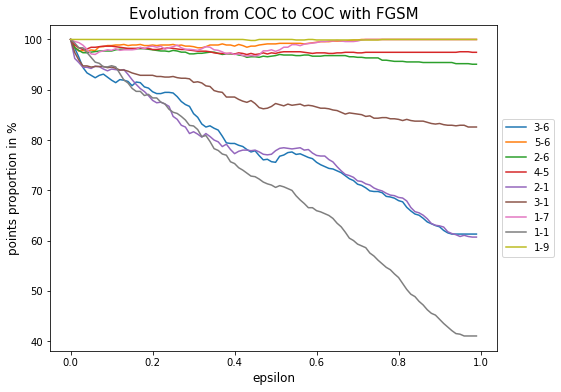

In [147]:
switch_plot(CMAT_BLOC, 0, 0, prange=PRANGE, net=NETS_NUM, ratio=True)

In [148]:
# save a switch-plot
switch_plot(CMAT_BLOC, 0, 0, prange=PRANGE, net=NETS_NUM, savefile="data_TOM/" + "switch-plot_COC-COC")

Switch-plot COC-COC saved in data_TOM/switch-plot_COC-COC


Visualize the global behaviour of a single network using the function ***behaviour_plot*** :

In [118]:
# multiplot_pos = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]

def behaviour_plot(cmat_cube, prange, net=(1,1), method="fgsm", ratio=False, show=True, savefile=None):
    """ Plot the divergence of each of the 5 labels. """
    
    ncmat = cmat_cube.shape[0]
    npts = int(np.sum(np.sum(cmat_cube[0])))
    
    if len(prange) < ncmat: # need to consider the initial setting without any attack
        prange = [0] + prange

    fig, axes = plt.subplots(2, 3, figsize=(15, 10)) #, sharey=True)
    plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
    fig.suptitle("Global behaviour of network {0}-{1} against {2} on {3} pts".format(net[0],net[1],method.upper(),npts), size=25)

    for k in range(5):
        plot_coord = (k//3,k%3)
        
        if ratio:
            norm_coeff = cmat_cube[0,k,k]
            for q in range(5):
                axes[plot_coord].plot(prange,100*cmat_cube[:,k,q]/norm_coeff, label=ACAS_labels[q]) #, color = labels_color[k])
            axes[plot_coord].set_ylabel("points proportion in %", size=14)
        else:      
            for q in range(5):
                axes[plot_coord].plot(prange,cmat_cube[:,k,q], label=ACAS_labels[q]) #, color = labels_color[k])
            axes[plot_coord].set_ylabel("number of points", size=14)
            
        axes[plot_coord].set_xlabel("intensity", size=14)
        axes[plot_coord].set_title("Divergence of {0}".format(ACAS_labels[k]), size=15)
    
    for i in range(5):
        cmat0_coeff = " [{0}%]".format(int(10000*cmat_cube[0,i,i]/npts)/100.0)
        axes[(1,2)].plot([], [], label = ACAS_labels[i] + cmat0_coeff)
    axes[(1,2)].get_xaxis().set_visible(False)
    axes[(1,2)].get_yaxis().set_visible(False)
    axes[(1,2)].spines['top'].set_visible(False)
    axes[(1,2)].spines['right'].set_visible(False)
    axes[(1,2)].spines['bottom'].set_visible(False)
    axes[(1,2)].spines['left'].set_visible(False)
    axes[(1,2)].legend(loc="center", fontsize="xx-large")
        
    if show and (savefile == None):
        plt.show()
    if savefile != None:
        plt.savefig(savefile) ; plt.close(fig)
        print("Network {0}-{1} behaviour-plot saved in {2}".format(net[0], net[1], savefile))

**Example :** Visualize the global behaviour of a single network.

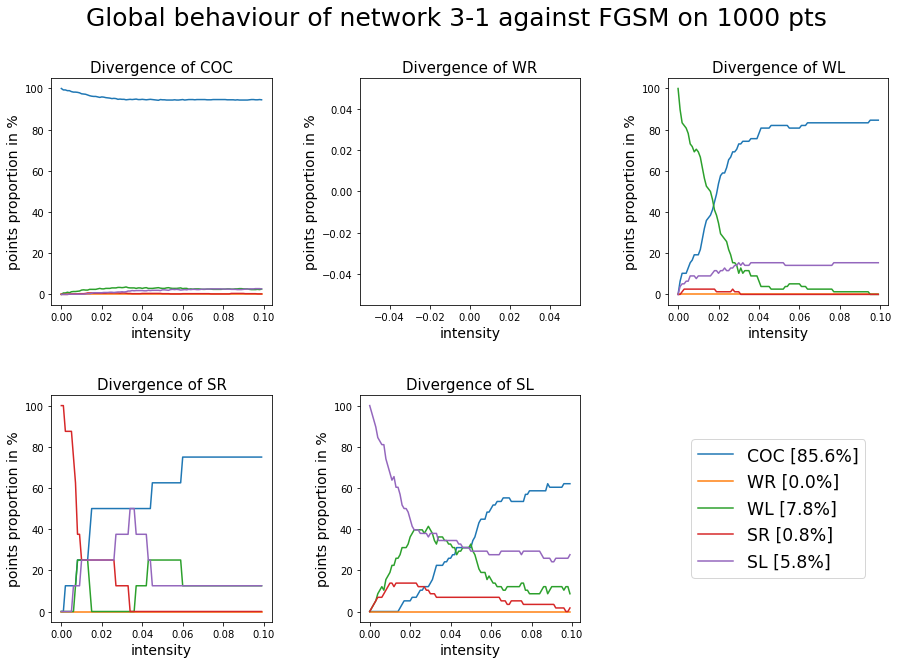

In [123]:
ind_net = 5 # 7 = full network = the only one with interesting behaviour plots...

behaviour_plot(CMAT_BLOC[ind_net], prange=PRANGE, net=NETS_NUM[ind_net], ratio=True)

In [128]:
# save several behaviour-plot
for inet in range(9):
    behaviour_plot(CMAT_BLOC[inet], prange=PRANGE, net=NETS_NUM[inet], ratio=True,
                   savefile = "data_TOM/" + "FGSM_#1000_0.001_23-05/" + "behaviour-plot_{0}-{1}".format(NETS_NUM[inet][0],NETS_NUM[inet][1]))

Network 3-6 behaviour-plot saved in data_TOM/FGSM_#1000_0.001_23-05/behaviour-plot_3-6
Network 5-6 behaviour-plot saved in data_TOM/FGSM_#1000_0.001_23-05/behaviour-plot_5-6
Network 2-6 behaviour-plot saved in data_TOM/FGSM_#1000_0.001_23-05/behaviour-plot_2-6
Network 4-5 behaviour-plot saved in data_TOM/FGSM_#1000_0.001_23-05/behaviour-plot_4-5
Network 2-1 behaviour-plot saved in data_TOM/FGSM_#1000_0.001_23-05/behaviour-plot_2-1
Network 3-1 behaviour-plot saved in data_TOM/FGSM_#1000_0.001_23-05/behaviour-plot_3-1
Network 1-7 behaviour-plot saved in data_TOM/FGSM_#1000_0.001_23-05/behaviour-plot_1-7
Network 1-1 behaviour-plot saved in data_TOM/FGSM_#1000_0.001_23-05/behaviour-plot_1-1
Network 1-9 behaviour-plot saved in data_TOM/FGSM_#1000_0.001_23-05/behaviour-plot_1-9


# 5 - Evaluate the saturation on the boundaries when using an attack

In [129]:
def get_saturated_coord(adv_pts, tol=1e-4):
    """ For every adversarial point 'a' in adv_pts, return 'm' where m[k]=1 if a[k] is close to a lower or upper boundary
        defined by inputs_domain and m[k]=0 otherwise ('close to' means at a distance < tol). """
    npts = adv_pts.shape[0]
    mask = np.zeros((npts,5))
    for i in range(5):
        binf = inputs_domain[0,i] ; bsup = inputs_domain[1,i]
        for k in range(npts):
            ki = adv_pts[k,i]
            if (ki - binf < tol) or (bsup - ki) < tol:
                mask[k,i] = 1
    return(mask)

Visualize the evolution of the level of saturation for each coordinates using the function ***saturation_plot*** :

In [136]:
def saturation_plot(base_pts, adv_pts, prange, net=(1,1), method="fgsm", show=True, savefile=None):
    """ Plot the saturation of the points coordinates as a function of the attack intensity (prange). """
    
    nset = adv_pts.shape[0] + 1
    npts = base_pts.shape[0]
    
    if len(prange) < nset: # need to consider the initial setting without any attack
        prange = [0] + prange

    sat_tab = np.zeros((nset,5))
    
    mask_init = get_saturated_coord(base_pts)
    sat_tab[0,:] = np.sum(mask_init, axis=0)
    
    for k in range(0,nset-1):
        mask_k = get_saturated_coord(adv_pts[k])
        sat_tab[k+1,:] = np.sum(mask_k, axis=0)
    
    fig = plt.figure(figsize=(8, 6))
    for k in range(5):
        plt.plot(prange, sat_tab[:,k], label=input_latex_names[k])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize="xx-large")
    plt.xlabel("intensity", size=14) ; plt.ylabel("number of points", size=14)
    plt.title("Saturation of network {0}-{1} with {2} on {3} points".format(net[0],net[1],method.upper(), npts), size=16)
    
    if show and (savefile == None):
        plt.show()
    if savefile != None:
        plt.savefig(savefile, bbox_inches="tight") ; plt.close(fig)
        print("Network {0}-{1} behaviour-plot saved in {2}".format(net[0], net[1], savefile))

**Example :** Visualize the evolution of the level of saturation for each of the 5 coordinates.

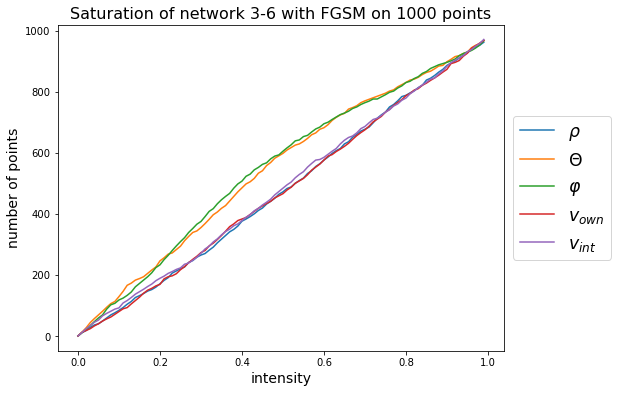

In [149]:
ind_net = 0

saturation_plot(BASE_PTS, ALL_ADV_PTS[ind_net], net=NETS_NUM[ind_net], prange=PRANGE)

In [150]:
# save saturation-plot
ind_net = 0

saturation_plot(BASE_PTS, ALL_ADV_PTS[ind_net], prange=PRANGE, net=NETS_NUM[ind_net],
                savefile = "data_TOM/" + "FGSM_#1000_0.01_20-05/" + "saturation-plot_{0}-{1}".format(NETS_NUM[ind_net][0],NETS_NUM[ind_net][1]))

Network 3-6 behaviour-plot saved in data_TOM/FGSM_#1000_0.01_20-05/saturation-plot_3-6
